# HW6 Reinforcement Learning

*   Author: Yuege Xie (EID:yx4256)
*   Python version: Python 3
*   CS 391L Machine Learning HW2

In [1]:
cd /content/drive/My Drive/2020-ml/reinforcement-learning

/content/drive/My Drive/2020-ml/reinforcement-learning


In [2]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1023)
# check the python version
from platform import python_version
print("Current python version is {}".format(python_version()))
%matplotlib inline

Current python version is 3.6.9


In [0]:
class QTable:
    def __init__(self, env, lr=0.9, eps=0.1, gamma=0.9):
        self.env = env
        self.states = env.states
        self.actions = env.actions
        self.lr = lr
        self.eps = eps
        self.gamma = gamma
        self.qtable = {}
        # initiaize q table
        for s in self.states:
            self.qtable[s] = {}
            for a in self.actions:    
                self.qtable[s][a] = 0.0
        self.change = 0
    
    def get_action(self, state):
        if np.random.uniform() > self.eps:
            action = max(self.actions, key=lambda k: self.qtable[state][k])
        else:
            idx =  np.random.choice(len(self.actions))
            action = self.actions[idx]
        return action

    def update(self, state, training=False):
        action = self.get_action(state)
        next_state, reward = self.env.step(state, action)
        if training:
            if self.env.cur_pos[0] != self.env.col-1:
                q_next = reward + self.gamma * max(self.qtable[next_state].values())
            else:
                q_next = reward
            q_now = self.qtable[state][action]
            self.qtable[state][action] += self.lr * (q_next - q_now)
        return next_state

In [0]:
def plot_results(env, title):
    
    # plot grid
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(1, 1, 1)
    plt.xlim(-.5, env.col-0.5)
    plt.ylim(-.5, env.row-0.5)
    y_minor_ticks = np.arange(0, env.row, 1)
    x_minor_ticks = np.arange(0, env.col, 1)
    ax.set_xticks(x_minor_ticks, minor=True)
    ax.set_yticks(y_minor_ticks, minor=True)  
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(which='both')

    if env.obs:
        for ob in env.obs:
            plt.plot(ob[0], ob[1], 's', color='r', markersize=12)

    if env.litter:
        for li in env.litter:
            plt.plot(li[0], li[1], '*', color='g', markersize=18)
            
    # plot initial and end points
    plt.plot(env.trace['init'][0], env.trace['init'][1] , 
             'D', color='b', markersize=12)
    env.end = env.trace['pos'][-1]
    plt.plot(env.end[0], env.end[1], 'D', color='b', markersize=12)

    # plot trace
    last = env.trace['init']
    for i in range(len(env.trace['pos'])):
        x, y = env.trace['pos'][i][0], env.trace['pos'][i][1]
        plt.scatter(x, y, color='orange', s=200, alpha=0.3)
        if env.trace['pos'][i] != last:
            dx, dy = env.trace['act'][i][0], env.trace['act'][i][1]
            plt.arrow(last[0], last[1], dx, dy, 
                  head_width=0.2, head_length=0.2, fc='k', ec='k')
        last = env.trace['pos'][i]
    plt.title(f"Simulation of Agent: {title}")
    plt.tight_layout()
    plt.savefig(f"./plots/{title}.pdf")
    plt.show()  

In [0]:
def train(env_class, episodes, max_iter=500):
    env = env_class(col=25, row=6, seed=1023)
    qt = QTable(env)
    
    for ep in range(episodes):
        env = env_class(col=25, row=6, seed=23+np.random.randint(int(1e5)))
        qt.env = env
        next_state = qt.env.init
        i = 0
        while qt.env.cur_pos[0] != qt.env.col-1 and i<max_iter:
            next_state = qt.update(next_state, training=True)
            i=i+1
    return qt

In [0]:
def simulate(qt, env_class, seed, max_iter=1e3):
    qt.eps = -1
    qt.env = env_class(col=25, row=6, seed=seed)

    next_state = qt.env.init
    i = 0
    while qt.env.cur_pos[0] != qt.env.col-1 and i<max_iter:
        next_state = qt.update(next_state, training=False)
        i=i+1
    return qt.env

## "Forth" Module

In [0]:
def check_step(state, col, row):
    state[0] = max(0, state[0])
    state[0] = min(col-1, state[0])
    state[1] = max(0, state[1])
    state[1] = min(row-1, state[1])
    return tuple([state[0], state[1]])

class EnvForth:
    def __init__(self, col , row, seed):
        self.col = col
        self.row = row
        self.states = [(a,b) for a in range(col) for b in range(row)]
        self.actions = [(0,1), (0,-1), (-1,0), (1,0)]
        self.obs, self.litter = None, None
        
        np.random.seed(seed)
        self.init = (0, np.random.choice(row))
        self.trace = {'init': self.init,'act':[], 'pos':[]}
        self.cur_pos = self.init

    def step(self, state, action): 
        next_state = [state[0]+action[0], state[1]+action[1]]
        next_state = check_step(next_state, self.col, self.row)
        reward_val = self.reward(state, action, next_state)
        self.trace['act'].append(action)
        self.trace['pos'].append(next_state)
        self.cur_pos = next_state
        return next_state, reward_val

    def reward(self, state, action, next_state):
        # reach the goal
        if next_state[0] == self.col-1:
            return 100
        elif next_state[0] > state[0]: 
            return 5
        elif next_state[0] <= state[0]: 
            return -5

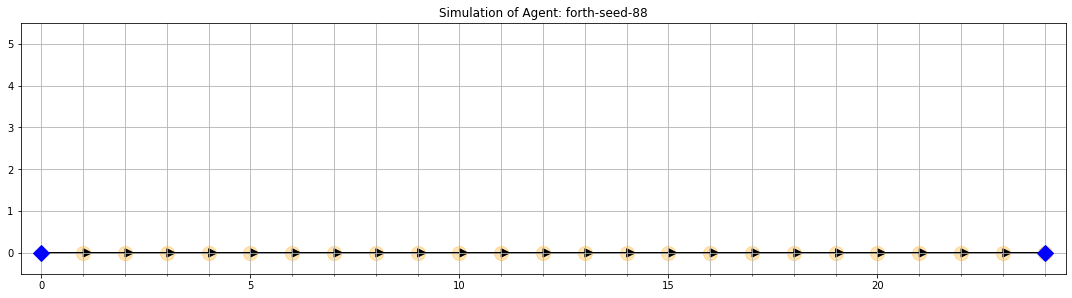

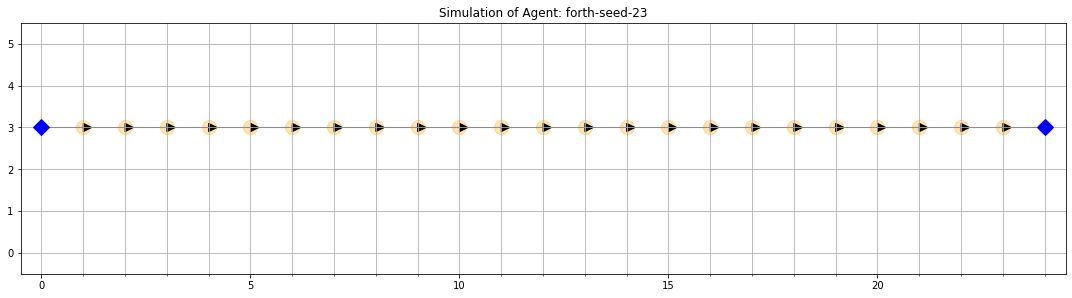

In [8]:
env_forth = EnvForth
qt_forth = train(env_forth, episodes=int(1e4))
for seed in [88, 23]:
    sample = simulate(qt_forth, env_forth, seed=seed)
    plot_results(sample, f"forth-seed-{seed}")

## "Stay on the Path" Module

In [0]:
class EnvStay(EnvForth):
    def __init__(self, col , row, seed):
        super().__init__(col , row, seed)
    def reward(self, state, action, next_state):
        # reach the goal
        if next_state[0] == self.col-1:
            return 100
        elif next_state[0] > state[0]: 
            return 5
        elif next_state[0] < state[0]: 
            return -5
        elif next_state == state:
            return -50
        else:
            return 0 

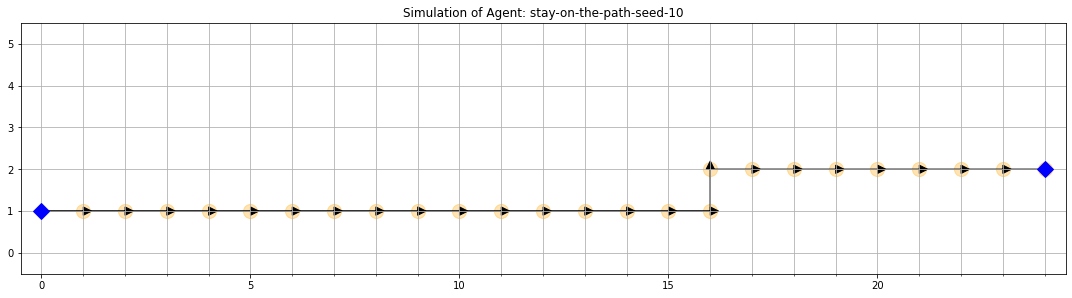

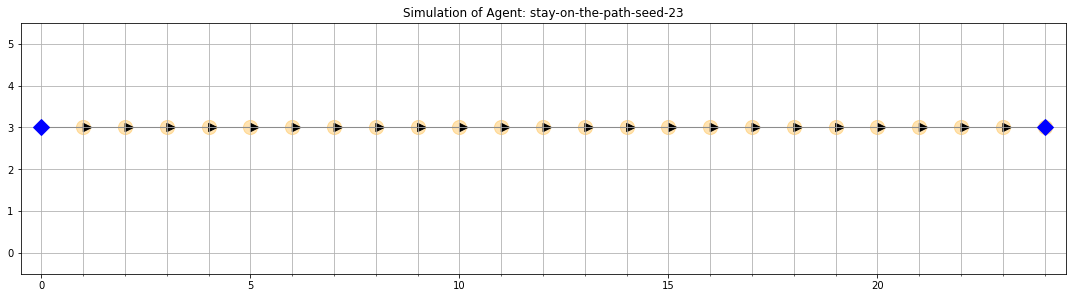

In [10]:
env_stay = EnvStay
qt_stay = train(env_stay, episodes=int(1e4))
for seed in [10,23]:
    sample = simulate(qt_stay, env_stay, seed)
    plot_results(sample, f"stay-on-the-path-seed-{seed}")

## "Obstacles" Module

In [0]:
class EnvObstacles:
    def __init__(self, col , row, seed):
        self.col = col
        self.row = row
        tmp = [0,1]
        self.states = [(a,b,c,d) for a in tmp for b in tmp 
                       for c in tmp for d in tmp]
        self.actions = [(0,1), (0,-1), (-1,0), (1,0)] # up, down, left, right
        
        np.random.seed(seed)
        self.init_pos = (0, np.random.choice(row))
        self.trace = {'init': self.init_pos, 'act':[], 'pos':[]}
        self.litter = None

        # set obstacles
        num = self.col * self.row // 5
        x = np.random.randint(0, self.col, num)
        y = np.random.randint(0, self.row, num)
        self.obs = set([(x[i], y[i]) for i in range(len(x))])
        if self.init_pos in self.obs:
            self.obs.remove(self.init_pos)
        # record current true state
        self.init = self.pos_to_state(self.init_pos)
        self.cur_pos = self.init_pos
    
    def pos_to_state(self, pos):
        abs_list = []
        for act in self.actions:
            if tuple(p+q for p, q in zip(act, pos)) in self.obs:
                abs_list.append(1)
            else:
                abs_list.append(0)
        state = tuple(abs_list)
        return state

    def step(self, state, action):
        next_pos = [self.cur_pos[0]+action[0], self.cur_pos[1]+action[1]]
        next_pos = check_step(next_pos, self.col, self.row)
        reward_val = self.reward(next_pos)
        next_state = self.pos_to_state(next_pos)
        # record action and position
        self.trace['act'].append(action)
        self.trace['pos'].append(next_pos)
        # change current position
        self.cur_pos = next_pos

        return next_state, reward_val

    def reward(self, next_pos):
        if next_pos in self.obs:
            return -30
        elif next_pos[0] == self.col-1: 
            return 100
        elif next_pos[0] > self.cur_pos[0]: 
            return 5
        elif next_pos[0] <= self.cur_pos[0]: 
            return -5 

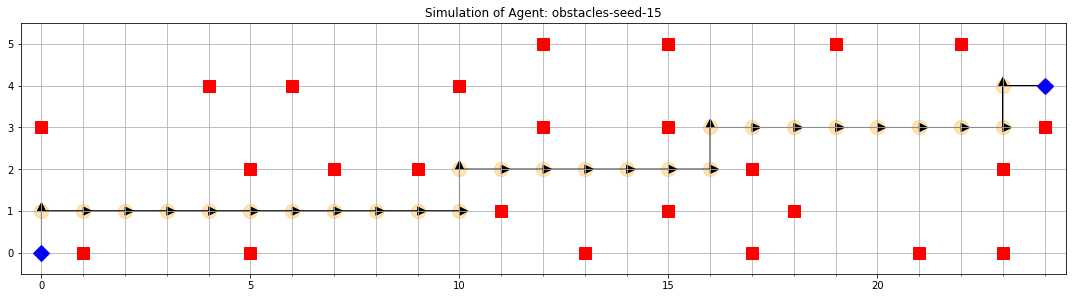

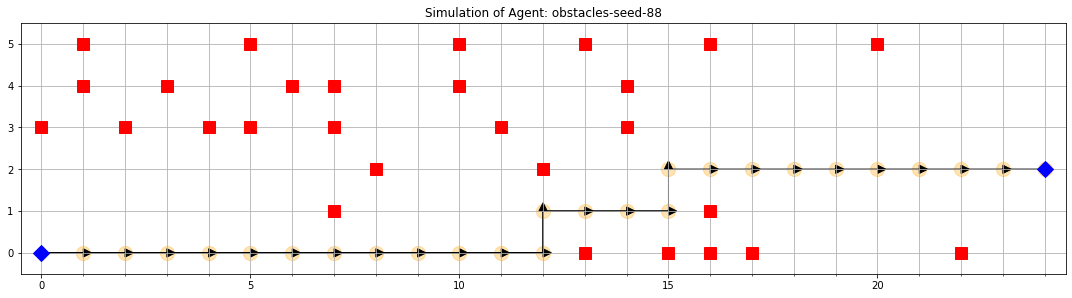

In [12]:
env_obs = EnvObstacles
qt_obs = train(env_obs, int(1e4))
for seed in [15, 88]:
    sample = simulate(qt_obs, env_obs, seed)
    plot_results(sample, f"obstacles-seed-{seed}")

## "Litter" Module

In [0]:
class EnvLitter:
    def __init__(self, col , row, seed):
        self.col = col
        self.row = row
        tmp = [0,1]
        self.states = [(a,b,c,d) for a in tmp for b in tmp 
                       for c in tmp for d in tmp]
        self.actions = [(0,1), (0,-1), (-1,0), (1,0)] # up, down, left, right
        
        np.random.seed(seed)
        self.init_pos = (0, np.random.choice(row))
        self.trace = {'init': self.init_pos, 'act':[], 'pos':[]}
        self.obs = None

        # set obstacles
        num = self.col * self.row // 5
        x = np.random.randint(0, self.col, num)
        y = np.random.randint(0, self.row, num)
        self.litter = set([(x[i], y[i]) for i in range(len(x))])
        self.cur_litter = set([(x[i], y[i]) for i in range(len(x))])
        if self.init_pos in self.litter:
            self.litter.remove(self.init_pos)
            self.cur_litter.remove(self.init_pos)
        # record current true state
        self.init = self.pos_to_state(self.init_pos)
        self.cur_pos = self.init_pos
        
    
    def pos_to_state(self, pos):
        abs_list = []
        for act in self.actions:
            if tuple(p+q for p, q in zip(act, pos)) in self.cur_litter:
                abs_list.append(1)
            else:
                abs_list.append(0)
        state = tuple(abs_list)
        return state

    def step(self, state, action):
        next_pos = [self.cur_pos[0]+action[0], self.cur_pos[1]+action[1]]
        next_pos = check_step(next_pos, self.col, self.row)
        reward_val = self.reward(next_pos)
        next_state = self.pos_to_state(next_pos)
        # record action and position
        self.trace['act'].append(action)
        self.trace['pos'].append(next_pos)
        # change current position
        self.cur_pos = next_pos
        return next_state, reward_val

    def reward(self, next_pos):
        re = -3
        if next_pos[0] == self.col-1: 
            return 100
        if next_pos in self.cur_litter:
            self.cur_litter.remove(next_pos)
            re += 15
        if next_pos[0] > self.cur_pos[0]:
            re += 1
        return re

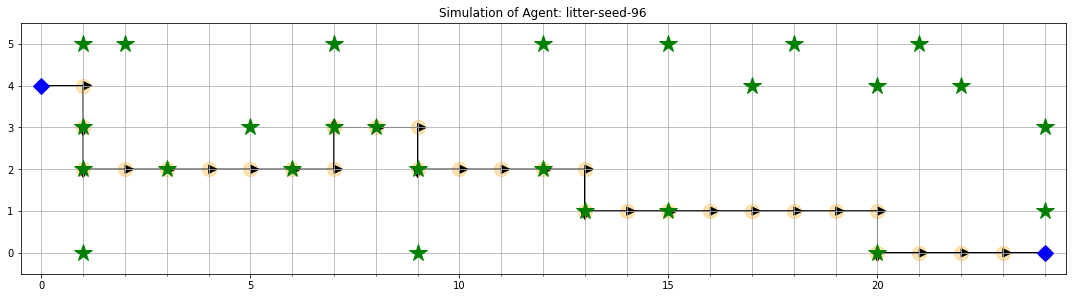

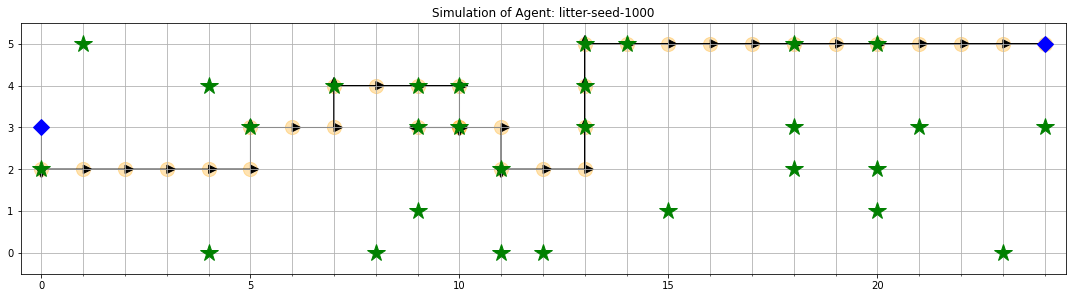

In [14]:
env_litter = EnvLitter
qt_litter = train(env_litter, int(1e4))
for seed in [96, 1000]:
    sample = simulate(qt_litter, env_litter, seed=seed)
    plot_results(sample, f"litter-seed-{seed}")

## Final Module

In [0]:
class EnvGlobal:
    def __init__(self, col , row, seed):
        self.col = col
        self.row = row
        tmp = [-1,0,1]
        self.states = [(a,b,c,d) for a in tmp for b in tmp 
                       for c in tmp for d in tmp]
        self.actions = [(0,1), (0,-1), (-1,0), (1,0)] # up, down, left, right
        
        np.random.seed(seed)
        self.init_pos = (0, np.random.choice(row))
        self.trace = {'init': self.init_pos, 'act':[], 'pos':[]}

        # set obstacles
        num = self.col * self.row // 5
        x = np.random.randint(0, self.col, num)
        y = np.random.randint(0, self.row, num)
        self.litter = set([(x[i], y[i]) for i in range(len(x))])
        self.cur_litter = set([(x[i], y[i]) for i in range(len(x))])

        xx = np.random.randint(0, self.col, num)
        yy = np.random.randint(0, self.row, num)
        self.obs = set([(xx[i], yy[i]) for i in range(len(xx))])
        self.obs = self.obs - self.litter
        
        if self.init_pos in self.litter:
            self.litter.remove(self.init_pos)
            self.cur_litter.remove(self.init_pos)
        elif self.init_pos in self.obs:
            self.obs.remove(self.init_pos)

        # record current true state
        self.init = self.pos_to_state(self.init_pos)
        self.cur_pos = self.init_pos
        
    
    def pos_to_state(self, pos):
        abs_list = []
        for act in self.actions:
            tmp = tuple(p+q for p, q in zip(act, pos)) 
            if tmp in self.cur_litter:
                abs_list.append(1)
            elif tmp in self.obs:
                abs_list.append(-1)
            else:
                abs_list.append(0)
        state = tuple(abs_list)
        return state

    def step(self, state, action):
        next_pos = [self.cur_pos[0]+action[0], self.cur_pos[1]+action[1]]
        next_pos = check_step(next_pos, self.col, self.row)
        reward_val = self.reward(next_pos)
        next_state = self.pos_to_state(next_pos)
        # record action and position
        self.trace['act'].append(action)
        self.trace['pos'].append(next_pos)
        # change current position
        self.cur_pos = next_pos
        return next_state, reward_val

    def reward(self, next_pos):
        re = -3
        if next_pos[0] == self.col-1: 
            return 100
        if next_pos in self.cur_litter:
            self.cur_litter.remove(next_pos)
            re += 20
        elif next_pos in self.obs:
            re -= 10
        if next_pos[0] > self.cur_pos[0]:
            re += 2
        if next_pos == self.cur_pos:
            re -= 20
        return re

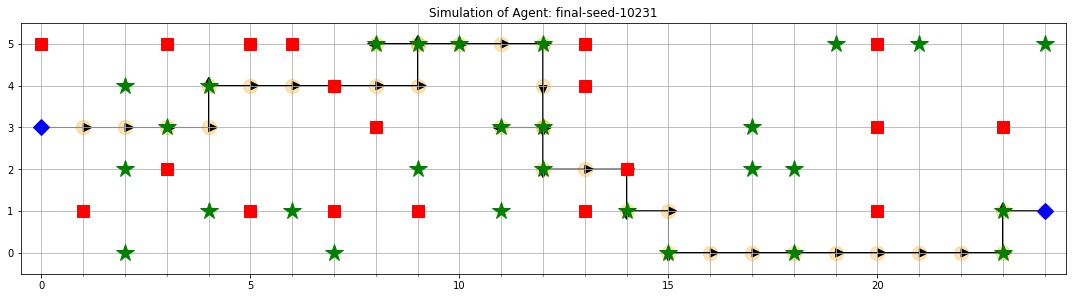

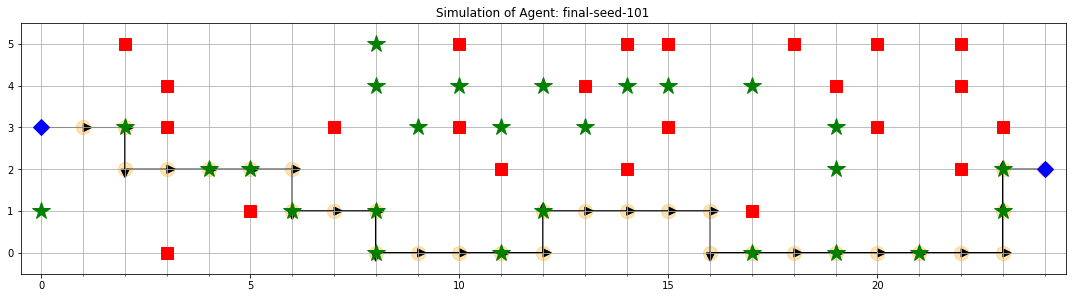

In [16]:
env = EnvGlobal
qt = train(env, int(1e4))
for seed in [10231, 101]:
    sample = simulate(qt, env, seed=seed)
    plot_results(sample, f"final-seed-{seed}")